# Set Up Imports

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Dense, Input, Flatten, Lambda
from keras.losses import binary_crossentropy, MeanSquaredError
from keras import Model
from keras import backend as K
import numpy as np
from tqdm import tqdm
print(f"Using Tensorflow v{tf.__version__}")

Using Tensorflow v2.11.0


# Set Up Waves Dataset

In [5]:
def normalize(tensor):
    tensor_minusmin = tensor - tensor.min()
    tensor_maxminusmin = tensor.max() - tensor.min()
    return tensor_minusmin / tensor_maxminusmin

def get_waves(file_name):
    # Read the raw audio from the .WAV file
    raw_audio = tf.io.read_file(filename=file_name)
    # Convert the raw audio to a waveform
    wave_bank, sample_rate = tf.audio.decode_wav(raw_audio)
    # Display the wavebank and sample_rate
    # display(wave_bank, sample_rate)
    wave_size = 256
    num_waves = 0
    waves = []
    wave_forms = np.transpose(wave_bank.numpy())
    for i in range(64):
        wave_form = wave_forms[0, i*wave_size:i*wave_size+wave_size]
        if wave_form.max() != wave_form.min():
            wave_form = normalize(wave_form)
            waves.append(wave_form)
            num_waves += 1    
    waves = tf.stack(waves)
    return waves

In [6]:
waves = get_waves("./audio_data/ENVELO01.WAV")
waves = tf.expand_dims(waves, 1)
waves = tf.expand_dims(waves, -1)
waves = tf.expand_dims(waves, -1)
display(waves[0].shape)

TensorShape([1, 256, 1, 1])

# Encoder

In [7]:
enc_input_shape = (1,256,1,1)
latent_dim = 16

class Encoder(Model):
    name="encoder"
    def __init__(self):
        super().__init__()
        self.training = True
        self.conv1 = Conv2D(filters=16, kernel_size=(4,1), 
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_1")
        self.conv2 = Conv2D(filters=32, kernel_size=(4,1),
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_2"
                            )
        self.flatten = Reshape((1,-1), name="flatten")
        self.mu = Dense(latent_dim, name="mu")
        self.log_var = Dense(latent_dim, name="log_var")
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        temp = self.flatten(x)
        mu = self.mu(temp)
        log_var = self.log_var(temp)
        if self.training:
            return [mu,log_var]
        else:
            return mu
    
    def eval(self):
        training = False     

# Decoder

In [8]:
dec_input_shape = (1,1,16,1)
latent_dim = 16

class Decoder(Model):
    name="decoder"
    def __init__(self):
        super().__init__()
        
        self.training = True
        self.dense = Dense(128, name='decoder_dense_1')
        self.reshape = Reshape((1,64,-1), name="decoder_reshape")
        self.conv1T = Conv2DTranspose(filters=16, kernel_size=(1,4),
                                      strides=(1,2), padding="same",
                                      activation="relu", name="conv2dT_1")
        self.conv2T = Conv2DTranspose(filters=1, kernel_size=(1,4), 
                                      strides=(1,2), padding="same",
                                      activation="sigmoid", name="decoder_output")
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1T(x)
        x = self.conv2T(x)
        return x
    
    def eval(self):
        training = False
        

# Variational Autoencoder

In [99]:
class Losses():
    def __init__(self):
        self.recon_loss = []
        self.kl_loss = []
        self.tv_loss = []
        self.total_loss = []

class VAE(Model):
    name = "vae"
    wave_size = 256
    def __init__(self):
        super().__init__()
        self.training = True
        self.variational_beta = 1
        self.encoder = Encoder()
        self.decoder = Sequential([
            Input(shape=(1,16,1)),
            Dense(128, name='decoder_dense_1'),
            Reshape((1,64,-1), name="decoder_reshape"),
            Conv2DTranspose(filters=16, kernel_size=(1,4),
                            strides=(1,2), padding="same",
                            activation="relu", name="conv2dT_1"),
            Conv2DTranspose(filters=1, kernel_size=(1,4), 
                            strides=(1,2), padding="same",
                            activation="sigmoid", name="decoder_output")
            ], name="decoder")
        self.recon_loss = keras.metrics.Mean(name="recon_loss")
        self.kl_loss = keras.metrics.Mean(name="kl_loss") 
        self.tv_loss = keras.metrics.Mean(name="tv_loss")
        self.total_loss = keras.metrics.Mean(name="total_loss")  
        self.loss_tracker = Losses() 
        
    def call(self, inputs):
        x = self.encoder(inputs)
        sampled_point = self.sample_normal_point(x[0],x[1])
        sampled_point = tf.expand_dims(sampled_point, -1)
        return self.decoder(sampled_point)
    
    def sample_normal_point(self, mu, log_var):
        if self.training:
            self.mu = mu
            self.log_var = log_var
            std = tf.math.exp(log_var/2)
            epsilon = K.random_normal(shape=K.shape(mu), stddev=std)
            sampled_point = mu + std * epsilon
            return sampled_point
        else:
            return mu
    
    def loss(self, y_true, y_pred):
        recon_loss = binary_crossentropy( 
                                         tf.reshape(y_true,(-1,self.wave_size)), 
                                         tf.reshape(y_pred,(-1,self.wave_size))
                                         )
        recon_loss = tf.reduce_sum(recon_loss)
        kl_loss = -0.5 * K.sum( 1 + self.log_var - K.pow(self.mu,2) - K.exp(self.log_var))
        tv_loss = K.sum(K.pow(y_pred[:,:,:-1] - y_pred[:,:,1:],2))
        total_loss = 10000*recon_loss + self.variational_beta * kl_loss + 100.1*tv_loss
        
        self.recon_loss.update_state(recon_loss)
        self.kl_loss.update_state(kl_loss)
        self.tv_loss.update_state(tv_loss)
        self.total_loss.update_state(total_loss)
        

        return total_loss
    
    def eval(self):
        self.encoder.eval()
        self.training = False

# Initialize the VAE

In [100]:
vae = VAE()
vae.encoder.build(enc_input_shape)
vae.build(enc_input_shape)
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  67728     
                                                                 
 decoder (Sequential)        (None, 1, 256, 1)         2385      
                                                                 
Total params: 70,121
Trainable params: 70,113
Non-trainable params: 8
_________________________________________________________________


# VAE training

In [101]:
vae.compile(optimizer='adam', loss=vae.loss)
history = vae.fit(waves, waves,
                epochs=2500,
                shuffle=True,
                validation_data=(waves, waves))

Epoch 1/2500
2/2 [==============================] - 2s 273ms/step - loss: 219562.8125 - recon_loss: 21.9197 - kl_loss: 1.0547 - tv_loss: 3.6466 - total_loss: 219562.8125 - val_loss: 218279.9688 - val_recon_loss: 21.7943 - val_kl_loss: 1.7484 - val_tv_loss: 3.3511 - val_total_loss: 218279.9688
Epoch 2/2500
2/2 [==============================] - 0s 33ms/step - loss: 217858.8438 - recon_loss: 21.7496 - kl_loss: 2.3622 - tv_loss: 3.5981 - total_loss: 217858.8438 - val_loss: 216621.0312 - val_recon_loss: 21.6295 - val_kl_loss: 4.1478 - val_tv_loss: 3.2192 - val_total_loss: 216621.0312
Epoch 3/2500
2/2 [==============================] - 0s 33ms/step - loss: 215907.5625 - recon_loss: 21.5588 - kl_loss: 5.5255 - tv_loss: 3.1338 - total_loss: 215907.5625 - val_loss: 214279.4062 - val_recon_loss: 21.3936 - val_kl_loss: 10.3316 - val_tv_loss: 3.3296 - val_total_loss: 214279.4062
Epoch 4/2500
2/2 [==============================] - 0s 33ms/step - loss: 213708.0312 - recon_loss: 21.3338 - kl_loss: 1

# Tests

In [120]:
vae.eval()

## Compare Initial Waves and Decoded Waves

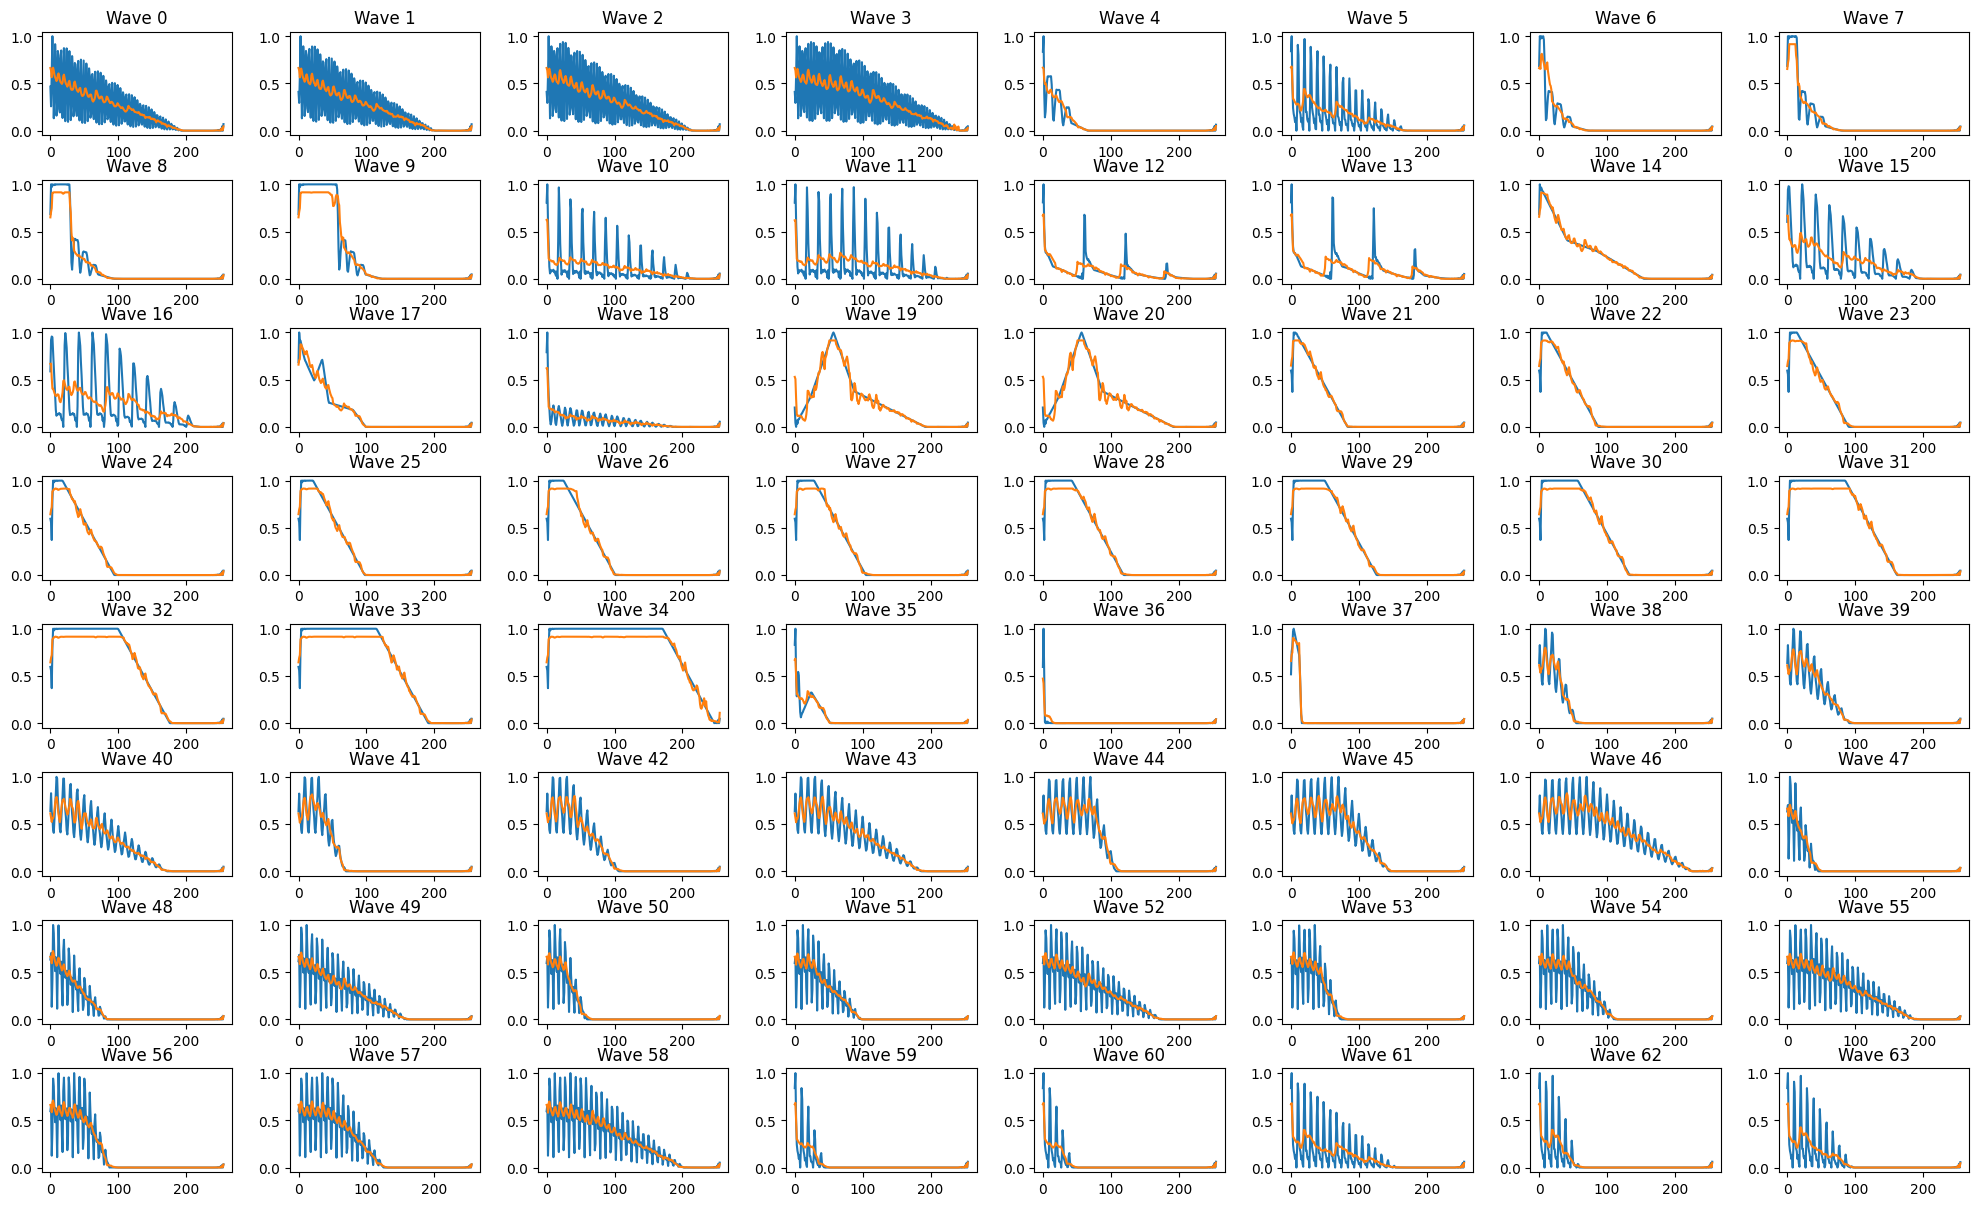

In [121]:
import matplotlib.pyplot as plt

figs, axs = plt.subplots(8,8,figsize=(20, 12)) 
figs.tight_layout()
for i in range(64):
    y = int(i/8)
    x = int(i%8)
    axs[y, x].plot(tf.squeeze(waves[i]))
    axs[y, x].plot(tf.squeeze(tf.squeeze(vae(waves[i]))))
    axs[y, x].set_title(f"Wave {i}")

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

fig_dir = "./wave_figs/wave_comparisons/"
figs.savefig(fname=f"{fig_dir}wave_comparisons_{timestr}.png", bbox_inches='tight')

## Compare adjacent waves

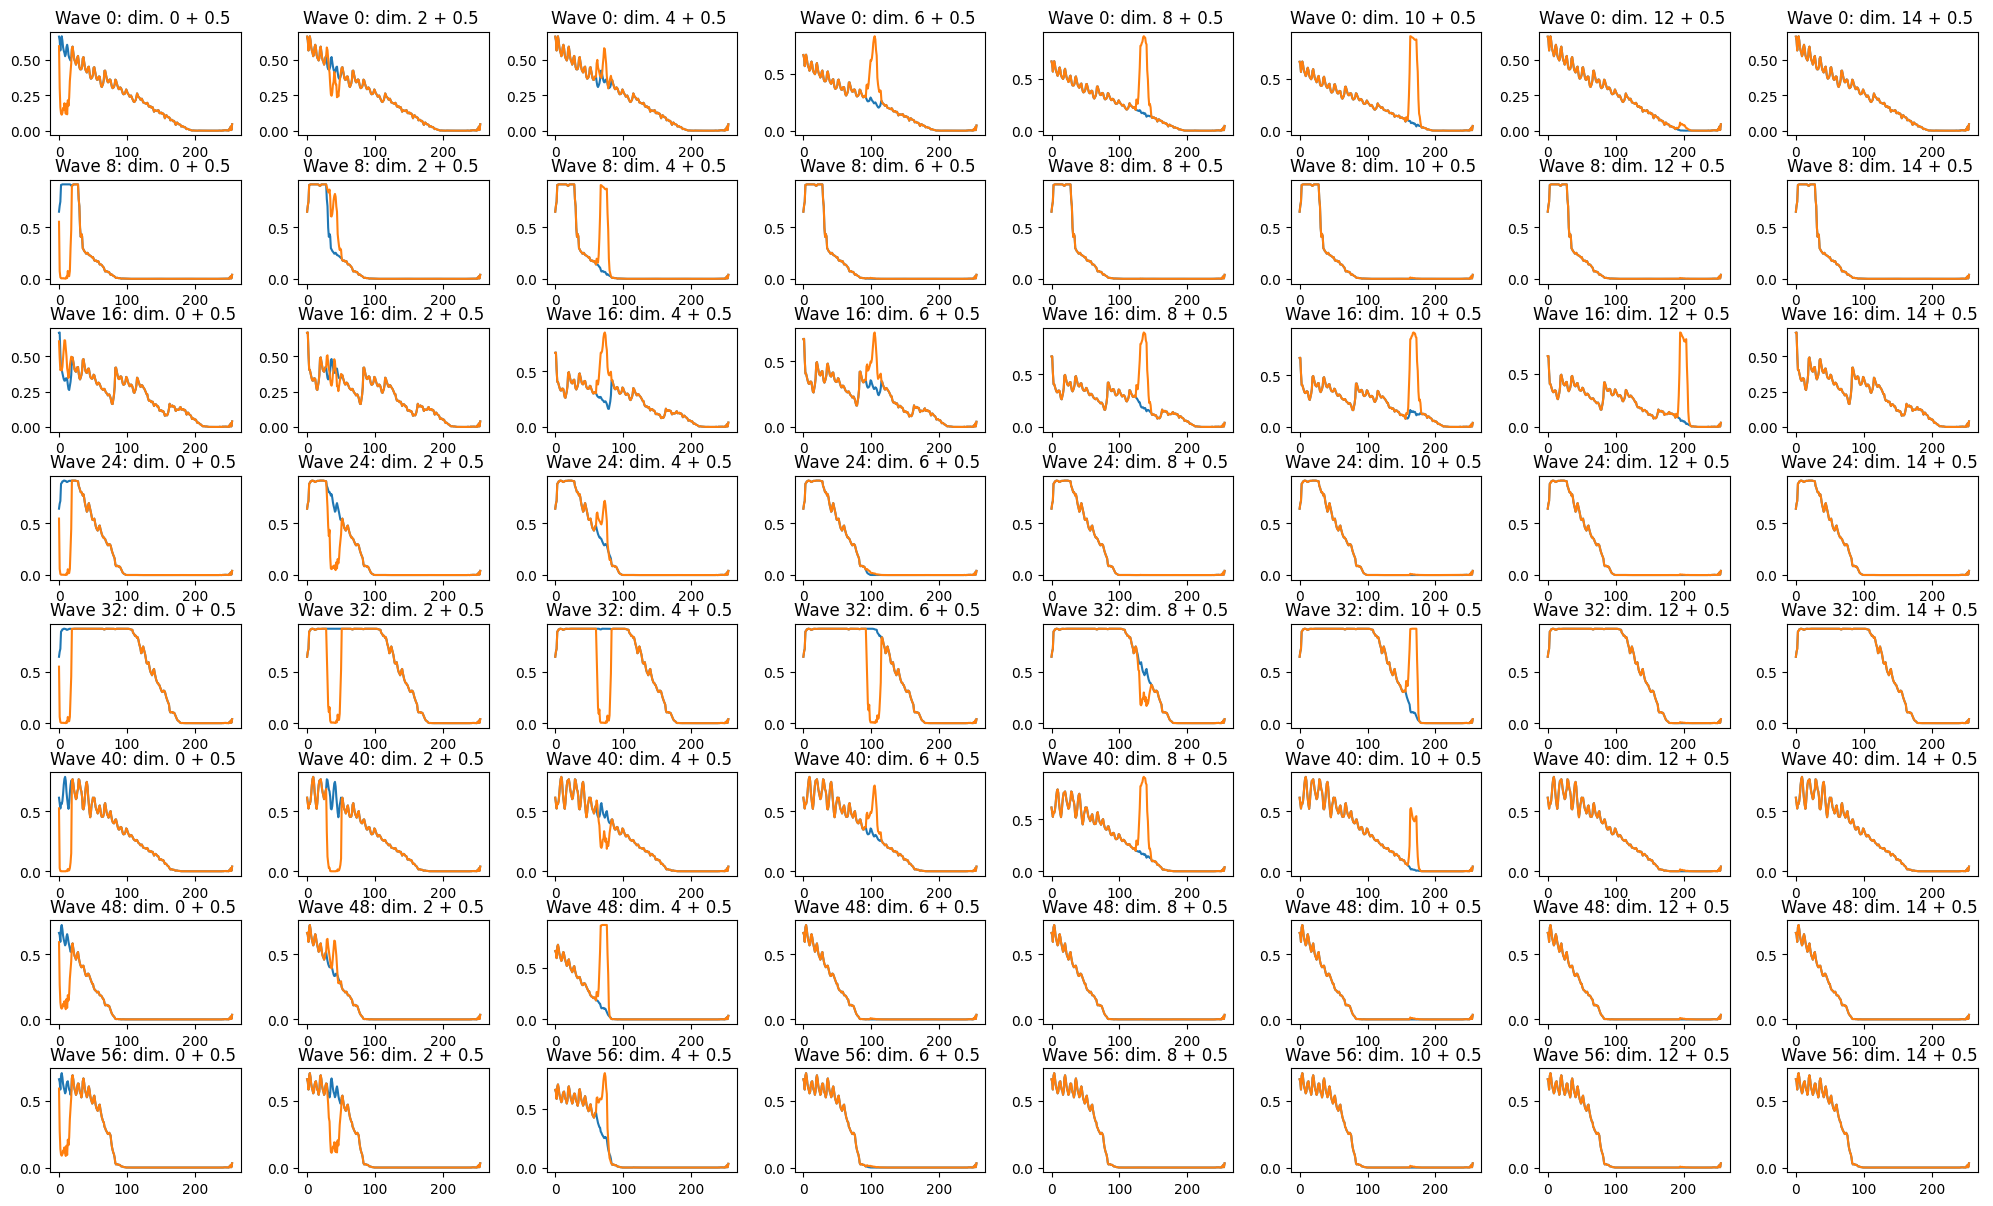

In [122]:
inc_arrays = []
modification = 0.5
for i in range(16):
    if i%2 == 0:
        inc_array = np.zeros((1,1,16))
        inc_array[0,0,i] = modification
        inc_arrays.append(tf.expand_dims(tf.convert_to_tensor(inc_array, dtype='float32'), -1))

figs, axs = plt.subplots(8,8,figsize=(20, 12)) 
figs.tight_layout()
for y in range(8):
    i = int(y*8)
    encoded_wave = vae.encoder(waves[i])[0]
    encoded_wave = tf.expand_dims(encoded_wave, -1)

    decoded_wave = vae(waves[i])
    for x in range(8):
        modified_latent_point = encoded_wave + inc_arrays[x]
        modified_decoded = vae.decoder(modified_latent_point)
        axs[y, x].plot(tf.squeeze(decoded_wave))
        axs[y, x].plot(tf.squeeze(modified_decoded))
        axs[y, x].set_title(f"Wave {i}: dim. {x*2} + {modification} ")

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

fig_dir = "./wave_figs/wave_modifications/"
figs.savefig(fname=f"{fig_dir}wave_mods_{timestr}.png", bbox_inches='tight')


## Loss

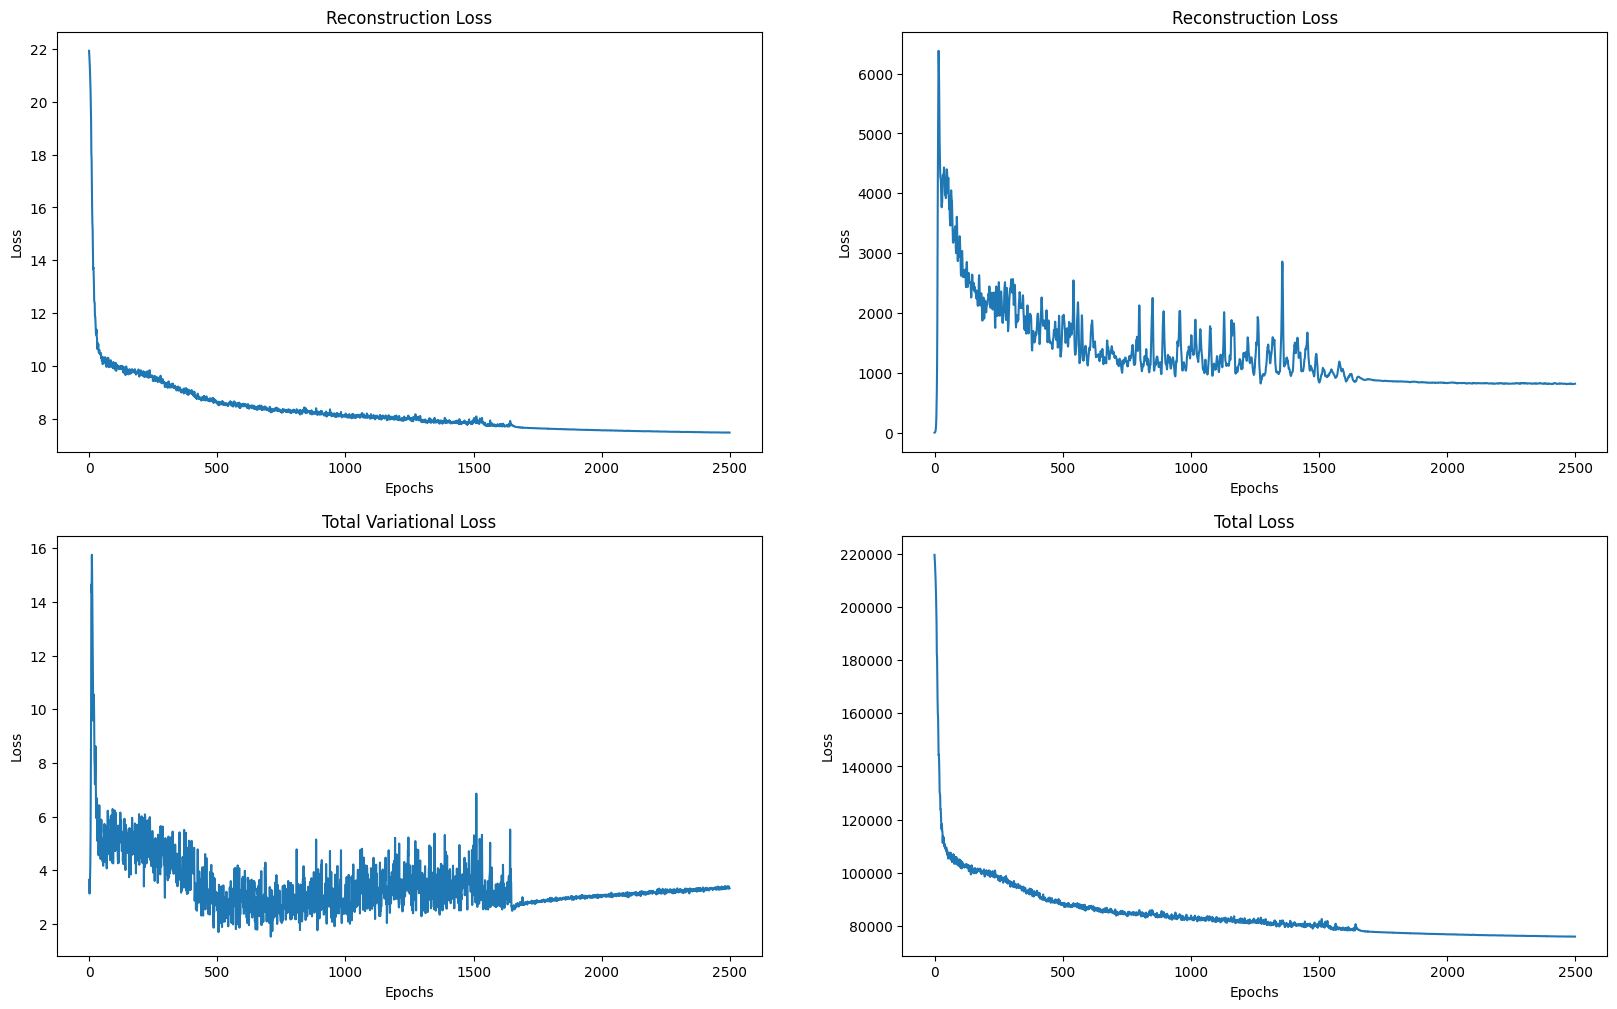

In [123]:
figs, axs= plt.subplots(2,2, figsize=(20, 12)) 
axs[0,0].plot(history.history['recon_loss'])
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Reconstruction Loss')

axs[0,1].plot(history.history['kl_loss'])
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('KL Loss')

axs[1,0].plot(history.history['tv_loss'])
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_title('Total Variational Loss')

axs[1,1].plot(history.history['loss'])
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title('Total Loss')

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

fig_dir = "./wave_figs/wave_comparisons/"
figs.savefig(fname=f"{fig_dir}loss_{timestr}.png", bbox_inches='tight')

# Save the model

In [125]:
vae_models_dir = "./keras_vae_models/"
vae.decoder.save(f"{vae_models_dir}/keras_vae.h5")